# Replicate the CERES model

## The CERES model

The following is the CERES model as desicrbed in ["Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells"](https://www.nature.com/articles/ng.3984#Sec24) (Meyeres *et al*, 2017).


$
\quad D_{ij} = q_i \lgroup \sum_{k \in G_i} (h_k + g_{kj}) + \mathcal{f} (\sum_{l \in L_i} C_{lj}) \rgroup + o_i + \epsilon
$

where:

- $D_{ij}$: sgRNA $i$ depletion in cell line $j$
- $q_i$: "guide activity score... to mitigate the influence of low-quality reagents" (restricted $[0,1]$)
- $G_i$: the genes targeted by sgRNA $i$
- $h_k$: "shared" (non-cell-line-specific) effect of gene $k$
- $g_{kj}$: cell-line-specific effect in cell line $j$ and gene $k$
- $\mathcal{f}_j$: piecewise linear spine to model copy number effect
- $L_i$: target loci of sgRNA $i$
- $C_{lj}$: copy number of target locus $l$ in cell line $j$
- $o_i$: sgRNA-sepcific effect to account for noise in the measurement of sgRNA abundance in the reference pool
- $\epsilon$: normal error

In [2]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
from theano import tensor as tt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import string
import warnings
from pathlib import Path
import pymc3_helpers as pmhelp

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

### Data preparation

In [3]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

SAMPLED_GENES=['KRAS', "BRAF", "DPH7", "KF3C"]
SAMPLED_DEPMAPIDS=data[["depmap_id"]].drop_duplicates().sample(n=40).depmap_id.to_list()

data = data[~np.isnan(data.segment_mean)]
data = data[data['hugo_symbol'].isin(SAMPLED_GENES)]
data = data[data['depmap_id'].isin(SAMPLED_DEPMAPIDS)]

data.head(n=10)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,segment_mean,copy_number,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
4225,AATTACTACTTGCTTCCTGT,a375skincj3-311cas9_repa_p6_batch3,-1.549750,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.143535,2.209217,0,False,NaN,NaN,NaN,NaN,False,4.266037
4230,AGAGGAGTACAGTGCAATGA,a375skincj3-311cas9_repa_p6_batch3,-0.730231,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.143535,2.209217,0,False,NaN,NaN,NaN,NaN,False,4.266037
4236,ATACCCAATAGAGTCCGAGG,a375skincj3-311cas9_repa_p6_batch3,-1.583222,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.472983,2.775953,1,False,missense_mutation,FALSE,TRUE,TRUE,False,3.667892
4248,CCTCAGGTGTCACATCCCGG,a375skincj3-311cas9_repa_p6_batch3,-0.775751,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.079963,2.113982,0,False,NaN,NaN,NaN,NaN,False,4.167519
4251,CGAATATGATCCAACAATAG,a375skincj3-311cas9_repa_p6_batch3,0.239417,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.143535,2.209217,0,False,NaN,NaN,NaN,NaN,False,4.266037
4266,GCACCACTCCACCGAGTCCG,a375skincj3-311cas9_repa_p6_batch3,-0.403133,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.079963,2.113982,0,False,NaN,NaN,NaN,NaN,False,4.167519
4288,GGGCCAGGCTCTGTTCAACG,a375skincj3-311cas9_repa_p6_batch3,-2.012851,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.472983,2.775953,1,False,missense_mutation,FALSE,TRUE,TRUE,False,3.667892
4292,GGTGGACACCGAGCTGACCG,a375skincj3-311cas9_repa_p6_batch3,-2.156874,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.079963,2.113982,0,False,NaN,NaN,NaN,NaN,False,4.167519
4298,GTCCGCAGCCGAAGAGGCCG,a375skincj3-311cas9_repa_p6_batch3,-0.264441,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.472983,2.775953,1,False,missense_mutation,FALSE,TRUE,TRUE,False,3.667892
4308,TCATCAGCAGTGACTCCACA,a375skincj3-311cas9_repa_p6_batch3,0.661678,3,True,ACH-002003,NaN,skin,melanoma,WT,...,1.079963,2.113982,0,False,NaN,NaN,NaN,NaN,False,4.167519


In [4]:
print(f"testing with {data.shape[0]} data points")

testing with 1044 data points


In [5]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into categorical."""
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=ordered)
    return df


cat_cols = [
    "sgrna",
    "replicate_id",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
    "chromosome",
]

for col in cat_cols:
    data = make_cat(data, col)

In [6]:
def count_unique(df, col):
    """Count the number of unique values in a column."""
    return len(df[col].unique())


def get_indices(df, col):
    """Get a list of the indices for a column."""
    return df[col].cat.codes.to_list()


num_sgrnas = count_unique(data, "sgrna")
num_genes = count_unique(data, "hugo_symbol")
num_cell_lines = count_unique(data, "depmap_id")

sgrna_idx = get_indices(data, "sgrna")
gene_idx = get_indices(data, "hugo_symbol")
cell_line_idx = get_indices(data, "depmap_id")

In [7]:
data["segment_mean_z"] = data["segment_mean"].apply(lambda x: np.min((x, 10)))
data["segment_mean_z"] = data.groupby("hugo_symbol")["segment_mean_z"].apply(
    lambda x: (x - np.mean(x)) / np.std(x)
)

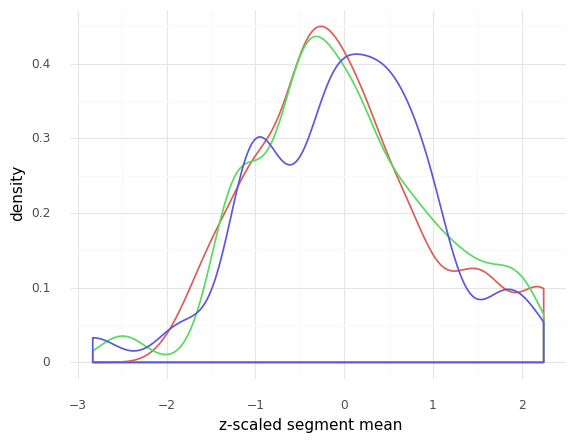

<ggplot: (8789751417835)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="segment_mean_z"))
    + gg.geom_density(gg.aes(color="hugo_symbol"), size=0.7)
    + gg.scale_color_discrete(guide=False)
    + gg.labs(x="z-scaled segment mean", y="density")
)

### Model 1.

Below is the model that will be fit with PyMC3 as the mimic of CERES.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} \beta_{ij} C_{ij} \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad \beta_{ij} \sim \mathcal{N}(-0.2, 0.5) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [9]:
%%time
with pm.Model() as ceres_m1:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 1, shape=(num_genes, num_cell_lines))
    #     beta_ij = pm.Normal("beta_ij", -0.2, 0.5, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = (
        q_i[sgrna_idx] * (h_k[gene_idx] + g_kj[gene_idx, cell_line_idx])
        + o_i[sgrna_idx]
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


CPU times: user 2.21 s, sys: 448 ms, total: 2.66 s
Wall time: 7.25 s


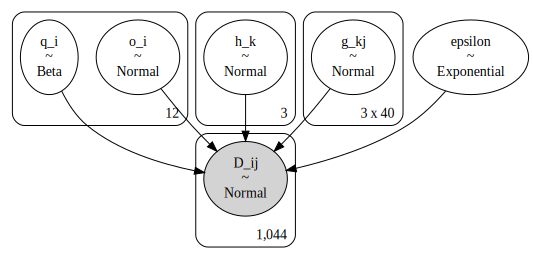

In [10]:
pm.model_to_graphviz(ceres_m1)

In [35]:
ceres_m1_cachedir = pymc3_cache_dir / "ceres_m1"

ceres_m1_samples = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=2000,
    tune=1000,
    chains=2,
    prior_check_samples=1000,
    ppc_samples=1000,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m1_cachedir,
    force=False
)

Loading cached trace and posterior sample...


In [38]:
az_ceres_m1 = az.from_pymc3(
    trace=ceres_m1_samples["trace"],
    model=ceres_m1,
    prior=ceres_m1_samples["prior_predictive"],
    posterior_predictive=ceres_m1_samples["posterior_predictive"],
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


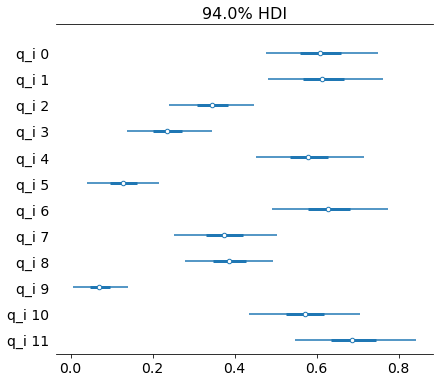

In [39]:
az.plot_forest(az_ceres_m1, var_names="q_i", combined=True)
plt.show()

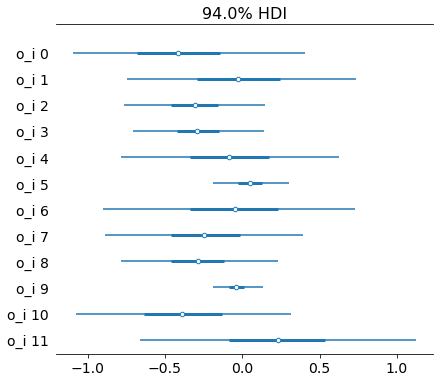

In [40]:
az.plot_forest(az_ceres_m1, var_names="o_i", combined=True)
plt.show()

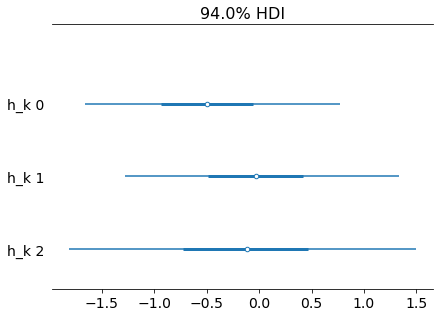

In [41]:
az.plot_forest(az_ceres_m1, var_names="h_k", combined=True)
plt.show()

In [46]:
gene_effect_post = ceres_m1_samples["trace"].get_values("g_kj")
gene_effect_post.shape

(4000, 3, 40)

In [47]:
gene_effect_mean = gene_effect_post.mean(axis=0)
gene_effect_mean.shape

(3, 40)

In [48]:
data['hugo_symbol'].cat.categories

Index(['KRAS', 'BRAF', 'DPH7'], dtype='object')

In [49]:
gene_effect_post_df = (
    pd.DataFrame(gene_effect_mean)
    .reset_index()
    .rename(columns={"index": "gene_idx"})
    .melt(id_vars="gene_idx", var_name="cell_line_idx", value_name="gene_effect")
    .assign(
        hugo_symbol=lambda d: [
            data["hugo_symbol"].values.categories[i] for i in d["gene_idx"].values
        ],
        depmap_id=lambda d: [
            data["depmap_id"].values.categories[i] for i in d["cell_line_idx"].values
        ],
    )
)
gene_effect_post_df.head(n=10)

,gene_idx,cell_line_idx,gene_effect,hugo_symbol,depmap_id
0,0,0,-0.809170,KRAS,ACH-002003
1,1,0,-2.136512,BRAF,ACH-002003
2,2,0,-2.888485,DPH7,ACH-002003
3,0,1,-1.020171,KRAS,ACH-000757
4,1,1,0.140421,BRAF,ACH-000757
5,2,1,-0.652821,DPH7,ACH-000757
6,0,2,-0.007476,KRAS,ACH-000528
7,1,2,0.480153,BRAF,ACH-000528
8,2,2,-0.170117,DPH7,ACH-000528
9,0,3,-0.113334,KRAS,ACH-000222


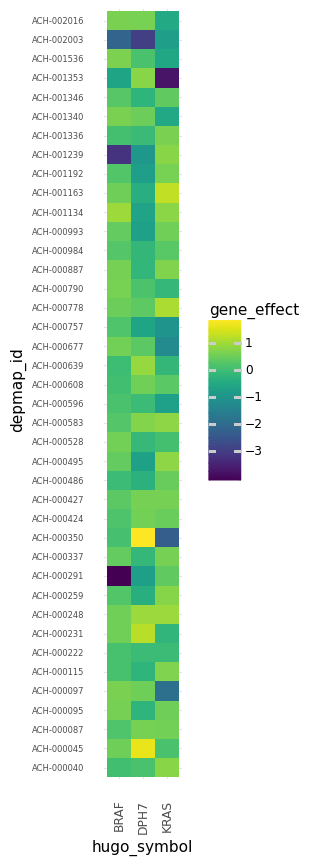

<ggplot: (8789678696298)>

In [53]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="gene_effect"))
    + gg.theme(
        figure_size=(1, 10),
        axis_text_x=gg.element_text(angle=90),
        axis_text_y=gg.element_text(size=6),
    )
)

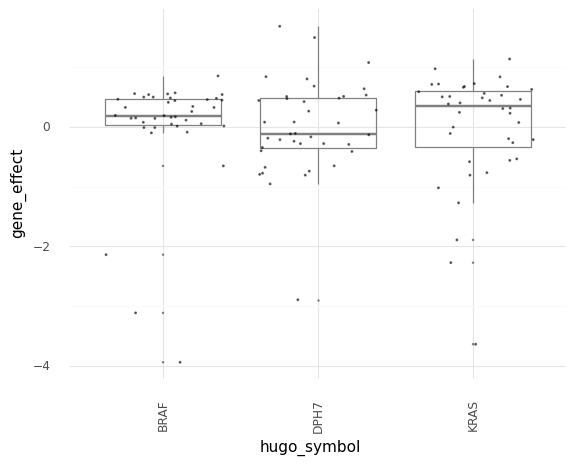

<ggplot: (8789676950038)>

In [54]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_size=-1)
    + gg.geom_jitter(alpha=0.5, size=0.2, height=0, width=0.4)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
)

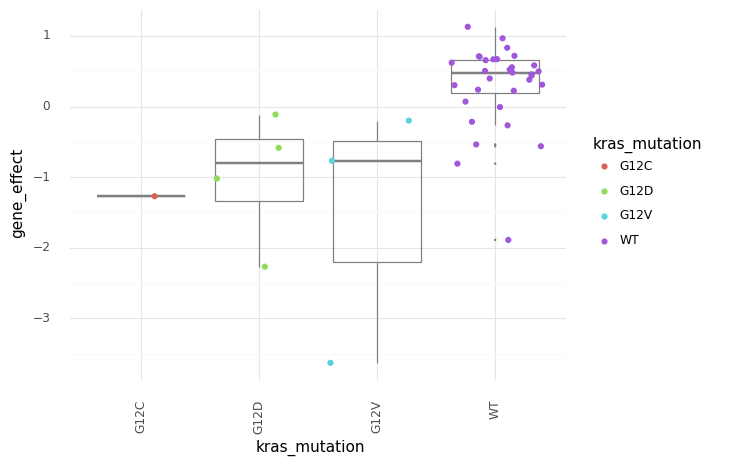

<ggplot: (8789676969819)>

In [55]:
kras_muts = data[["depmap_id", "kras_mutation"]].drop_duplicates()
kras_muts[["depmap_id", "kras_mutation"]] = kras_muts[
    ["depmap_id", "kras_mutation"]
].astype("str")

kras_gene_effect = (
    gene_effect_post_df[gene_effect_post_df.hugo_symbol == "KRAS"]
    .reset_index(drop=True)
    .merge(kras_muts, how="left", on=["depmap_id"])
)

(
    gg.ggplot(kras_gene_effect, gg.aes(x="kras_mutation", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_size=-1)
    + gg.geom_jitter(gg.aes(color="kras_mutation"), width=0.4, height=0)
    + gg.theme(axis_text_x = gg.element_text(angle=90, hjust=0.5, vjust=1))
)